# Biologically-Inspired Information Propagation in Synthetic Networks: Tree vs. Closed-Loop Structures¶

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random

In [ ]:
# Parameters
N = 100
DIST_THRESHOLD = 0.25  # Proximity threshold for full graph
LOOP_RADIUS = 0.2     # Local loop distance for adding triangles
MIN_CLUSTERING = 0.5  # Target minimum clustering coefficient

np.random.seed(30)

# Generate node positions
positions = np.random.rand(N, 2)
pos_dict = dict(enumerate(positions))

In [ ]:
# === Generate proximity graph and minimum spanning tree ===
def proximity_graph(positions, threshold):
    G = nx.Graph()
    for i, pos in enumerate(positions):
        G.add_node(i, pos=pos)
    dist_matrix = cdist(positions, positions)
    for i in range(N):
        for j in range(i + 1, N):
            if dist_matrix[i, j] < threshold:
                G.add_edge(i, j, weight=dist_matrix[i, j])
    return G

full_graph = proximity_graph(positions, DIST_THRESHOLD)
tree = nx.minimum_spanning_tree(full_graph)

In [ ]:
# === Start with tree and add localized loops ===
loopy = tree.copy()
all_edges = list(full_graph.edges())
random.shuffle(all_edges)

added_loops = 0
for u, v in all_edges:
    if loopy.has_edge(u, v):
        continue
    u_pos, v_pos = positions[u], positions[v]
    dist = np.linalg.norm(u_pos - v_pos)
    if dist < LOOP_RADIUS:
        # Look for a third node x to form a triangle
        for x in range(N):
            if x in (u, v):
                continue
            x_pos = positions[x]
            if (np.linalg.norm(u_pos - x_pos) < LOOP_RADIUS and
                np.linalg.norm(v_pos - x_pos) < LOOP_RADIUS):
                loopy.add_edge(u, v)
                loopy.add_edge(v, x)
                loopy.add_edge(x, u)
                added_loops += 1
                break

In [ ]:
# === Prune loopy edges to reduce edge count but keep clustering > threshold ===
extra_edges = set(loopy.edges()) - set(tree.edges())
pruned = loopy.copy()
removed_edges = 0

for u, v in list(extra_edges):
    if not pruned.has_edge(u, v):
        continue
    pruned.remove_edge(u, v)
    if not nx.is_connected(pruned) or nx.average_clustering(pruned) < MIN_CLUSTERING:
        pruned.add_edge(u, v)  # Restore if disconnects or too low clustering
    else:
        removed_edges += 1

In [ ]:
# === Final Clustering Coefficients ===
tree_clustering = nx.average_clustering(tree)
loopy_clustering = nx.average_clustering(loopy)
pruned_clustering = nx.average_clustering(pruned)

Tree edges: 99 — Avg Clustering: 0.0000
Loopy edges: 525 — Avg Clustering: 0.6406
Pruned edges: 195 — Avg Clustering: 0.5031
Tree edges removed in pruning: 330
Pruned graph connected? True
Loopy graph connected? True


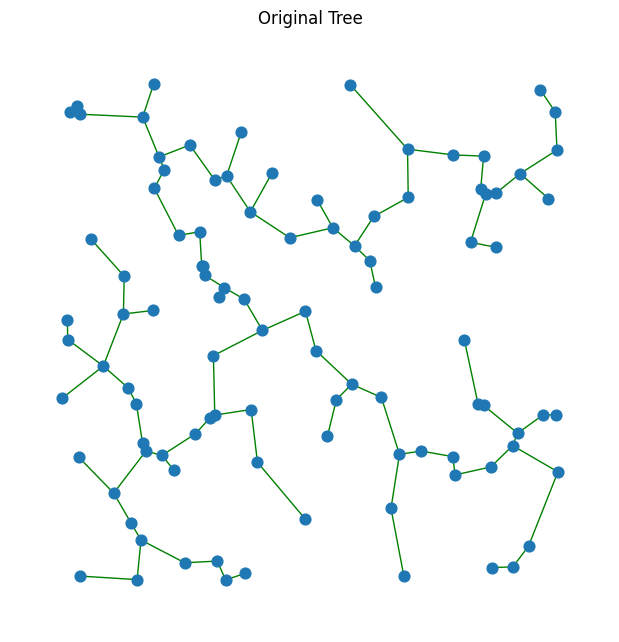

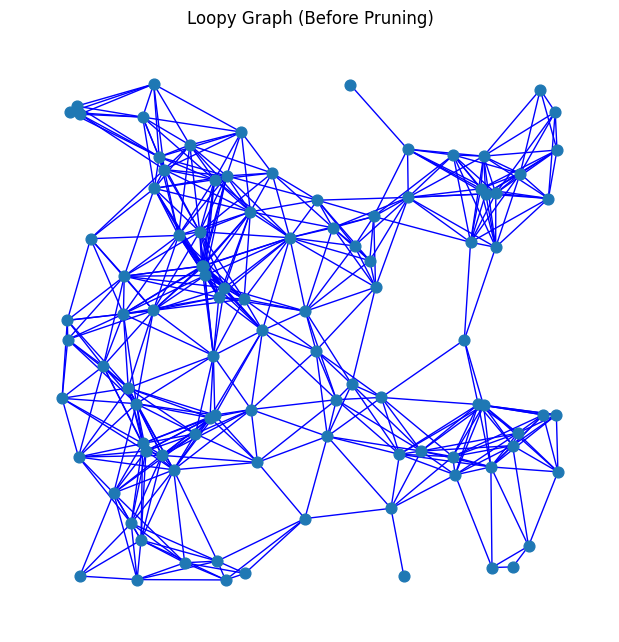

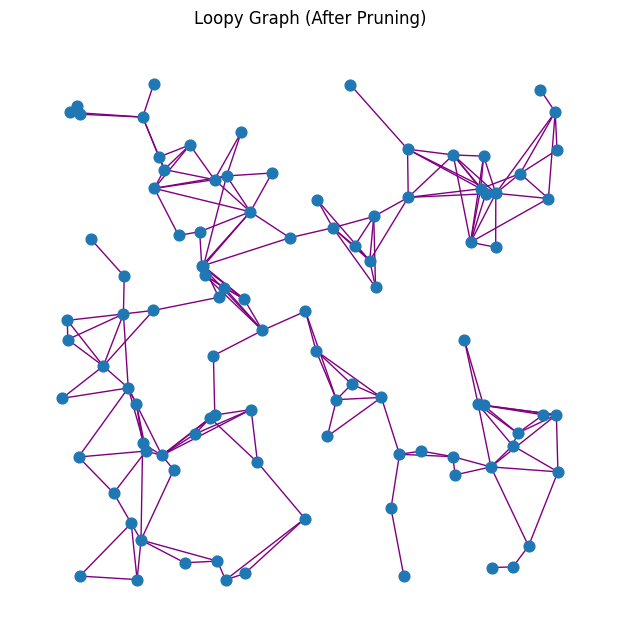

In [30]:
# === Summary ===
print(f"Tree edges: {tree.number_of_edges()} — Avg Clustering: {tree_clustering:.4f}")
print(f"Loopy edges: {loopy.number_of_edges()} — Avg Clustering: {loopy_clustering:.4f}")
print(f"Pruned edges: {pruned.number_of_edges()} — Avg Clustering: {pruned_clustering:.4f}")
print(f"Tree edges removed in pruning: {removed_edges}")
print(f"Pruned graph connected? {nx.is_connected(pruned)}")
print(f"Loopy graph connected? {nx.is_connected(loopy)}")

# === Visualize ===
plt.figure(figsize=(6, 6))
nx.draw(tree, pos=pos_dict, node_size=60, edge_color='green')
plt.title("Original Tree")
plt.show()

plt.figure(figsize=(6, 6))
nx.draw(loopy, pos=pos_dict, node_size=60, edge_color='blue')
plt.title("Loopy Graph (Before Pruning)")
plt.show()

plt.figure(figsize=(6, 6))
nx.draw(pruned, pos=pos_dict, node_size=60, edge_color='purple')
plt.title("Loopy Graph (After Pruning)")
plt.show()
